# Antibiotic Administration Route

Do we have any differences?

## Set up and reading the data

In [1]:
import os
import sys
from socket import gethostname

# this is for ffmpeg
os.environ['PATH'] += os.pathsep + os.path.expanduser('~/miniconda3/envs/bioinformatics/bin')

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

# color palettes use these
cpalette = 'coolwarm' # for health associated measures. Red = bad health
meshpalette = 'BrBG_r' # complementary for the coolwarm. Use when overlaying data
defpalette = 'mako' # Use for other images.

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

# Read the autoencoder
encoder_models = 'cluster_gbrfs'
# encoder_models = 'cluster_gbrfs_all'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['Cluster', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['Cluster'] = cluster_assignments['Cluster'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)
pc_df.columns = pc_df.columns.str.replace('Cluster', 'CPAF')

intcols = ['Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
pca = PCA(n_components=1)
md = metadata[intcols].dropna(subset=intcols)
md['Antibiotics_YN_enc'] = md['Antibiotics_YN'].astype('category').cat.codes
antibiotic_cols = ['Antibiotics_YN_enc', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
scaled = StandardScaler().fit_transform(md[antibiotic_cols])
tmp = pca.fit_transform(scaled)
md['Medications Score'] = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * 100

metadata['Medications Score'] = metadata.index.map(md['Medications Score'])

# cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score.tsv.gz'), compression='gzip', sep="\t", index_col=0)
cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score_tokenised.tsv.gz'), compression='gzip', sep="\t", index_col=0)
cluster_virulence.index = cluster_virulence.index.str.replace('Cluster', 'CPAF')
print("Data Initiated!")

Data Initiated!


Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


# Routes of administration

We have three routes of administration: IV, INH, and PO:

In [2]:
metadata[['IV', 'INH', 'PO']]

,IV,INH,PO
NAME,,,
1068841_20180306_S,0,0,0
1085876_20180227_S,0,0,1
1128691_20171206_S,1,1,1
1128691_20171218_S,1,0,0
1128691_20180116_S,0,1,0
...,...,...,...
895293_20180502_S,0,0,0
896213_20180427_S,1,0,0
913873_20180417_S,0,0,0


## Run the Gradient Boosted Random Forest

We used 124 estimators for the random forest classifier


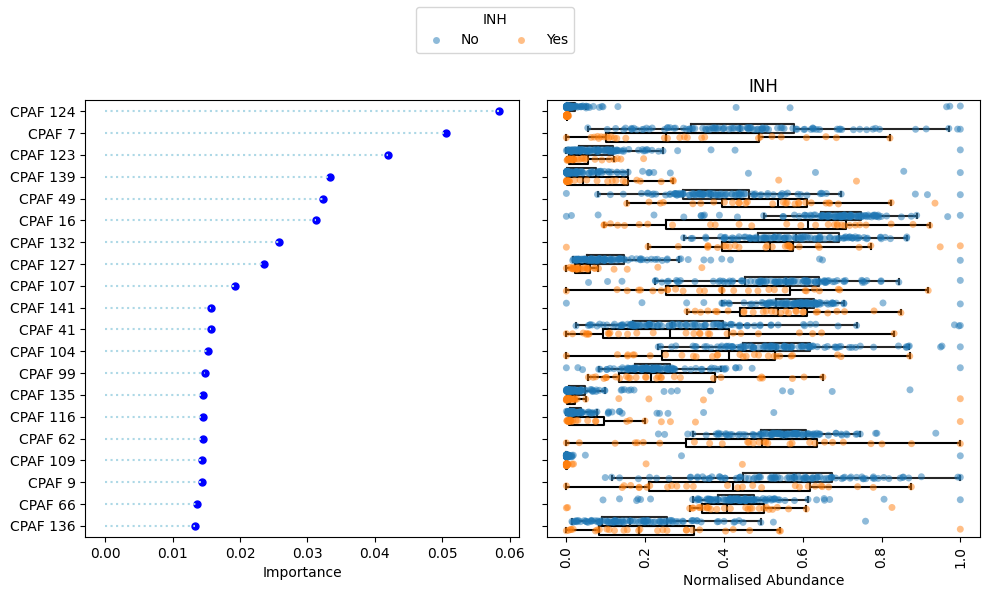

In [3]:
intcol = 'INH'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
cf_analysis_lib.plot_one_top_feature(merged_df, feature_importances_sorted, intcol, intcol_title, custom_labels)

We used 526 estimators for the random forest classifier
We used 124 estimators for the random forest classifier
We used 45 estimators for the random forest classifier


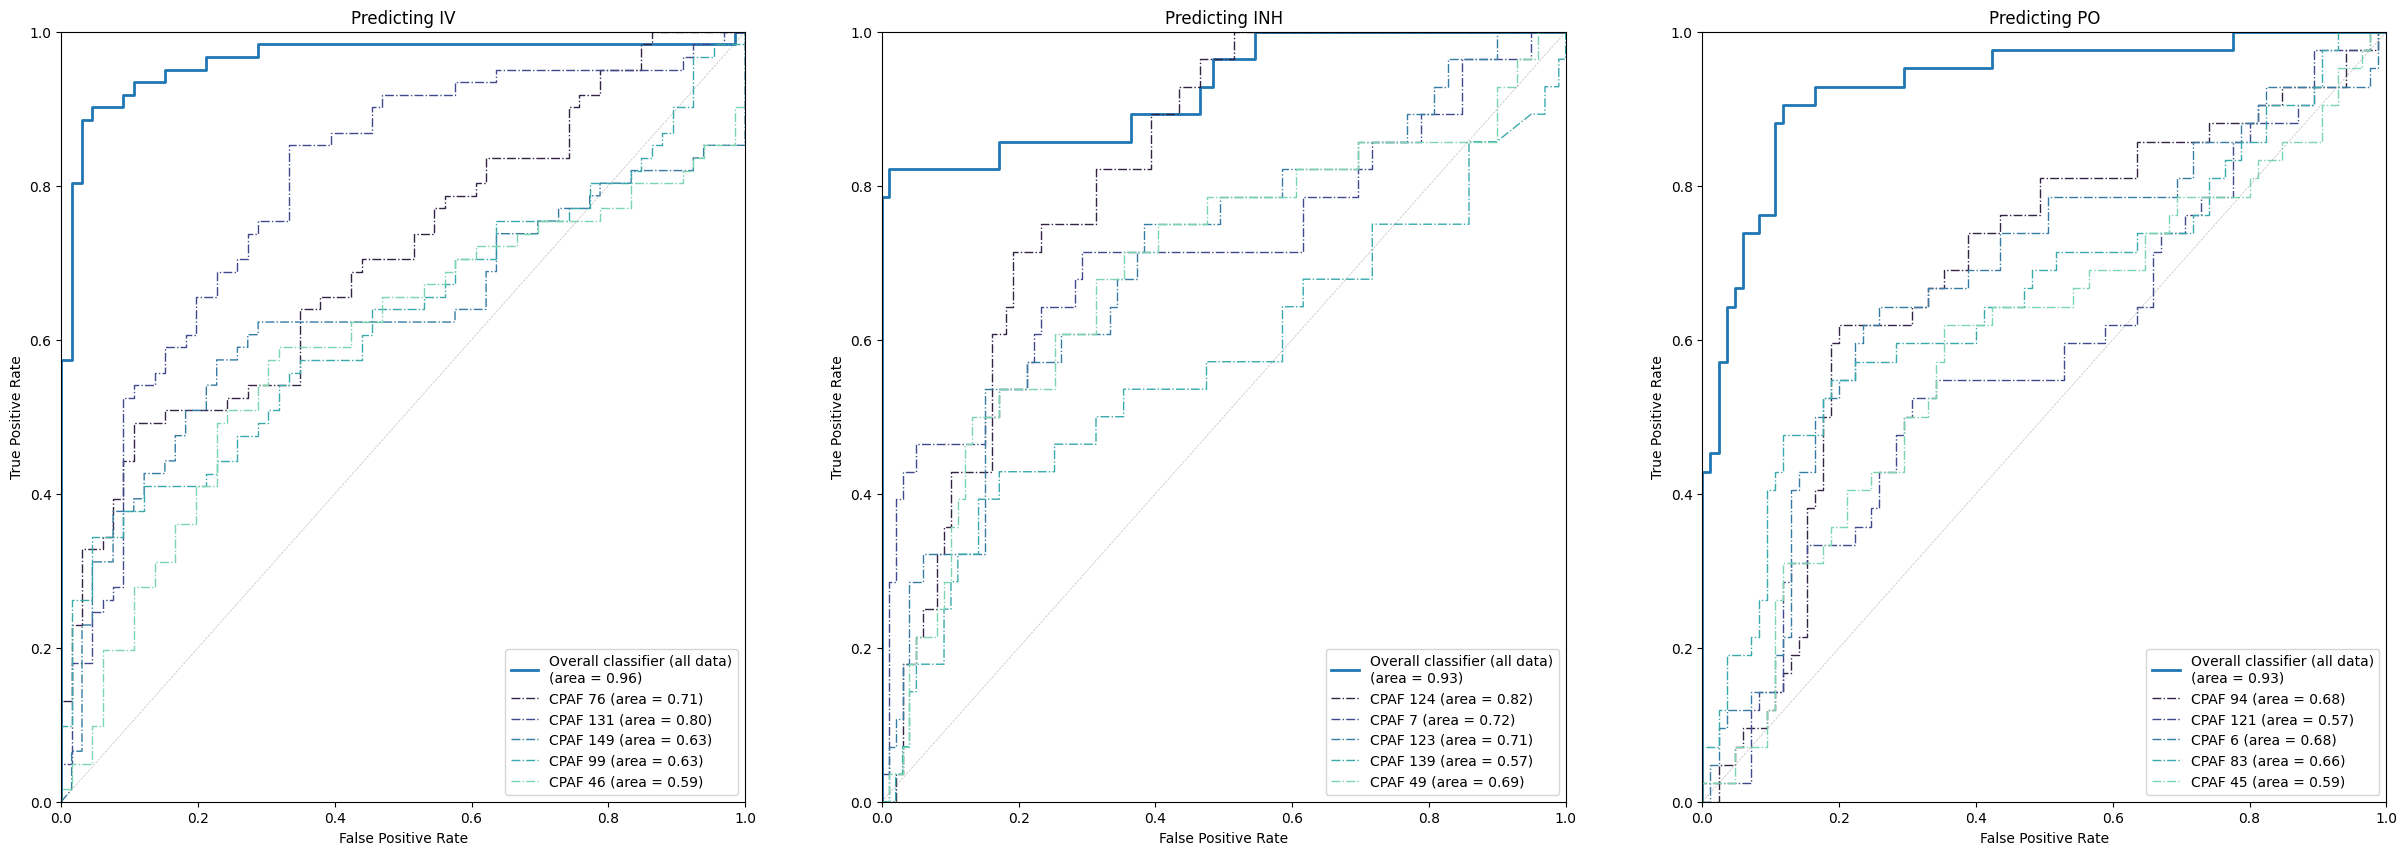

In [10]:
nrows=1 
ncols=3
fig, axes = plt.subplots(nrows, ncols, figsize=(30, 10))

intcols = ['IV', 'INH', 'PO']
for ix, intcol in enumerate(intcols):
    row, col = divmod(ix, ncols)
    # ax = axes[row, col]
    ax = axes[col]
    
    intcol_title = replace_index.sub('', intcol).replace('_', ' ')
    merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)
    
    categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)
    
    X = merged_df.drop(intcol, axis=1)
    y = merged_df[intcol]
    
    if categorical_data:
      model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
      met = 'classifier'
    else:
      model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
      met = 'regressor'
    
    print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
    ax = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, intcol_title, ax)
plt.savefig('img/ab_administration.png')
plt.show()

# Cluster Virulence

<Axes: xlabel='Cluster', ylabel='Normalised Jaccard'>

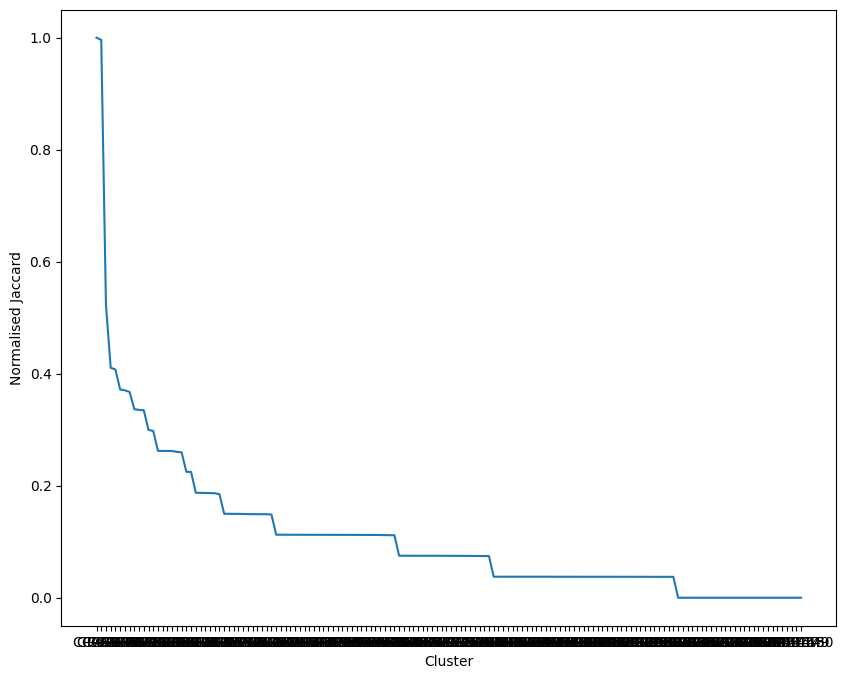

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=cluster_virulence.sort_values(by='Normalised Jaccard', ascending=False), x=cluster_virulence.index, y='Normalised Jaccard', ax=ax)

In [6]:
feature_importances_sorted[:10].index

Index(['CPAF 94', 'CPAF 121', 'CPAF 6', 'CPAF 83', 'CPAF 45', 'CPAF 99',
       'CPAF 11', 'CPAF 58', 'CPAF 127', 'CPAF 140'],
      dtype='object')

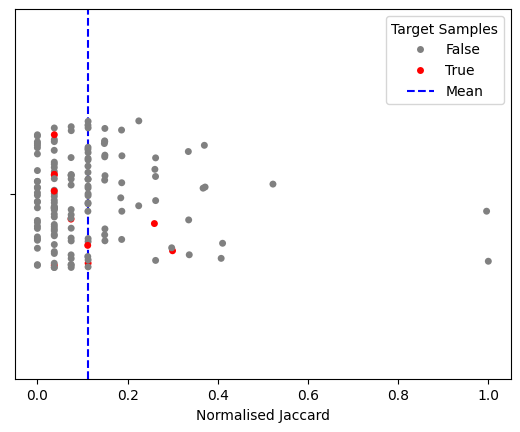

In [7]:
target_samples = feature_importances_sorted[:10].index
cluster_virulence['highlight'] = cluster_virulence.index.isin(target_samples)

sns.stripplot(data=cluster_virulence, x='Normalised Jaccard', y=['']*len(cluster_virulence), hue='highlight', palette={True: 'red', False: 'gray'}, jitter=0.2)
plt.axvline(cluster_virulence['Normalised Jaccard'].mean(), color='blue', linestyle='--', label='Mean')
plt.legend(title='Target Samples')

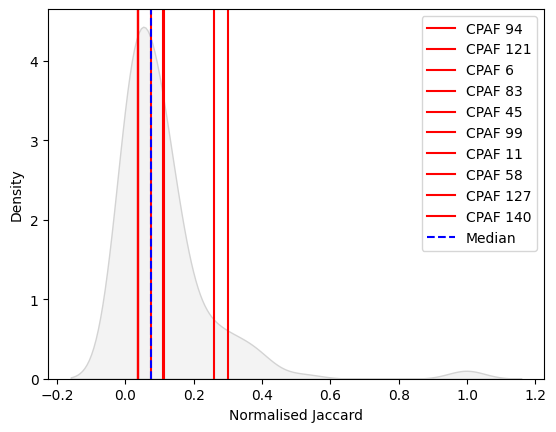

In [8]:
sns.kdeplot(cluster_virulence['Normalised Jaccard'], fill=True, color='lightgray')
for sample in target_samples:
    val = cluster_virulence.loc[sample, 'Normalised Jaccard']
    plt.axvline(val, color='red', linestyle='-', label=sample)
plt.axvline(cluster_virulence['Normalised Jaccard'].median(), color='blue', linestyle='--', label='Median')
plt.legend()

<Axes: xlabel='Normalised Jaccard'>

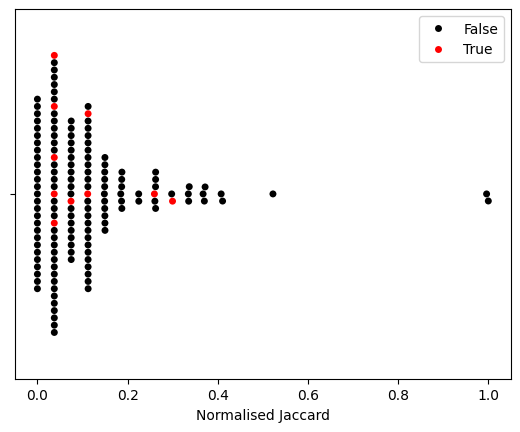

In [9]:
#sns.boxplot(x=cluster_virulence['Normalised Jaccard'], color='lightgray')
sns.swarmplot(x=cluster_virulence['Normalised Jaccard'],
              hue=cluster_virulence.index.isin(target_samples),
              palette={True: 'red', False: 'black'},
              dodge=False)